## VIT for image to image tasks

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

2024-04-04 16:49:18.483924: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from setup import *
from generators import * 
from utils import *
from denoising_unet import *

In [3]:
high_path_2010_2019 = "data/wind_speed_italy_CERRA_2010-2019.npy"
high_path_2020 = "data/wind_speed_italy_CERRA_2020.npy"
high_path_2009 = "data/wind_speed_italy_CERRA_2009.npy"
high_path_balcans = "data/wind_speed_BALCANS_CERRA_2009.npy"


low_path_2010_2019 = "data/wind_speed_italy_ERA5_2010-2019.npy"
low_path_2020 = "data/wind_speed_italy_ERA5_2020.npy"
low_path_2009 = "data/wind_speed_italy_ERA5_2009.npy"
low_path_balcans = "data/wind_speed_BALCANS_ERA5_2009.npy"

In [4]:
batch_size = 8

In [5]:
train_generator = DataGeneratorMemmap(high_path_2010_2019,low_path_2010_2019, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2010_2019,sequential=False,
                                      batch_size = batch_size, unet = True)

test_generator = DataGeneratorMemmap(high_path_2020,low_path_2020, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2020,sequential=False,
                                      batch_size = batch_size, unet = True)

full_test_generator = DataGeneratorMemmap(high_path_2020,low_path_2020, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2020,sequential=True,
                                      batch_size = batch_size, unet = True)

full_test_generator2009 = DataGeneratorMemmap(high_path_2009,low_path_2009, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2009,sequential=True,
                                      batch_size = batch_size, unet = True)

full_test_generatorBALCANS = DataGeneratorMemmap(high_path_balcans,low_path_balcans, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2009,sequential=True,
                                      batch_size = batch_size, unet = True)

In [6]:
input_shape = (256, 256, 4)

## Configure the hyperparameters

In [7]:
learning_rate = 1e-4
weight_decay = 1e-5
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 256  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 256
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 6
mlp_head_units = [
    512,
    256,
]  # Size of the dense layers of the final classifier


## Implement patch creation layer

In [8]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [9]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


In [10]:
# only used in postprocessing 
def ResidualBlock(width):
            def apply(x):
                input_width = x.shape[3]
                if input_width == width:
                    residual = x
                else:
                    residual = layers.Conv2D(width, kernel_size=1)(x)
                #x = layers.BatchNormalization(center=False, scale=False)(x)
                x = layers.LayerNormalization(axis=-1,center=True, scale=True)(x)
                x = layers.Conv2D(
                    width, kernel_size=3, padding="same", activation=keras.activations.swish
                )(x)
                x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
                x = layers.Add()([x, residual])
                return x
        
            return apply



def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def create_vit():
    inputs = keras.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    out = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    out = layers.Reshape((256, 256, 1))(out)

    #Post-processing (is it a good idea?) 
    #out = layers.Concatenate()([out, preprocess])

    #post = ResidualBlock(128)(out)
    #post = ResidualBlock(64)(post)
    #post = ResidualBlock(32)(out)

    #postprocess = layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(post)
    #out = layers.Conv2D(128, (3,3), 1, padding="same", activation=keras.activations.leaky_relu)(out)
    #out = layers.BatchNormalization()(out)
    #out = layers.Conv2D(128, (3,3), 1, padding="same", activation=keras.activations.leaky_relu)(out)
    #out = layers.BatchNormalization()(out)
    #out = layers.Conv2D(1, (3,3), 1, padding="same", activation=keras.activations.leaky_relu)(out)

    model = keras.Model(inputs=inputs, outputs=out)
    return model


In [11]:
model = create_vit()

optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
)


num_epochs = 1


In [12]:
model.summary(positions = [0.3, 0.6, 0.80, 1.])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape         ┃     Param # ┃ Connected to  ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256, 4)  │           0 │ -             │
│ (InputLayer)        │                      │             │               │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ patches (Patches)   │ (None, 256, 1024)    │           0 │ input_layer[… │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ patch_encoder       │ (None, 256, 256)     │     327,936 │ patches[0][0] │
│ (PatchEncoder)      │                      │             │               │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ layer_normalization │ (None, 256, 256)     │         512 │ patch_encode… │
│ (LayerNormalizatio… │                      │             │               │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ multi_head_attenti… │ (None, 256, 256)     │   2,103,552 │ layer_normal… │
│ (MultiHeadAttentio… │                      │             │ layer_normal… │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ add (Add)           │ (None, 256, 256)     │           0 │ multi_head_a… │
│                     │                      │             │ patch_encode… │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ layer_normalizatio… │ (None, 256, 256)     │         512 │ add[0][0]     │
│ (LayerNormalizatio… │                      │             │               │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ dense_1 (Dense)     │ (None, 256, 512)     │     131,584 │ layer_normal… │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ dropout_1 (Dropout) │ (None, 256, 512)     │           0 │ dense_1[0][0] │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ dense_2 (Dense)     │ (None, 256, 256)     │     131,328 │ dropout_1[0]… │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ dropout_2 (Dropout) │ (None, 256, 256)     │           0 │ dense_2[0][0] │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ add_1 (Add)         │ (None, 256, 256)     │           0 │ dropout_2[0]… │
│                     │                      │             │ add[0][0]     │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ layer_normalizatio… │ (None, 256, 256)     │         512 │ add_1[0][0]   │
│ (LayerNormalizatio… │                      │             │               │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ multi_head_attenti… │ (None, 256, 256)     │   2,103,552 │ layer_normal… │
│ (MultiHeadAttentio… │                      │             │ layer_normal… │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ add_2 (Add)         │ (None, 256, 256)     │           0 │ multi_head_a… │
│                     │                      │             │ add_1[0][0]   │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ layer_normalizatio… │ (None, 256, 256)     │         512 │ add_2[0][0]   │
│ (LayerNormalizatio… │                      │             │               │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ dense_3 (Dense)     │ (None, 256, 512)     │     131,584 │ layer_normal… │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ dropout_4 (Dropout) │ (None, 256, 512)     │           0 │ dense_3[0][0] │
├─────────────────────┼──────────────────────┼─────────────┼───────────────┤
│ dense_4 (Dense)     │ (None, 256, 256)     │     131,328 │ dropout_4[0]… │
├─────────────────────┼──────────────────────┼─────────────┼─────────────

 Total params: 14,533,376 (55.44 MB)

 Trainable params: 14,533,376 (55.44 MB)

 Non-trainable params: 0 (0.00 B)

## Compile, train, and evaluate the mode

In [13]:
history = model.fit(
    train_generator,
    #initial_epoch = 100, 
    #validation_data = valid_generator, 
    epochs=10,
    steps_per_epoch=500,
    #batch_size=32,
    #callbacks=[
        #keras.callbacks.LambdaCallback(on_epoch_end=post_saver)
    #],
)

Epoch 1/10


/home/faster/anaconda3/envs/keras3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.9633
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.7770
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.5943
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.4920
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.3729
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 0.2574
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.1970
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1573 
Epoch 9/10
  1/500 ━━━━━━━━━━━━━━━━━━━━ 1:10 142ms/step - loss: 0.1470

/home/faster/anaconda3/envs/keras3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.1411
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 0.1072


In [101]:
loss = history.history['loss']

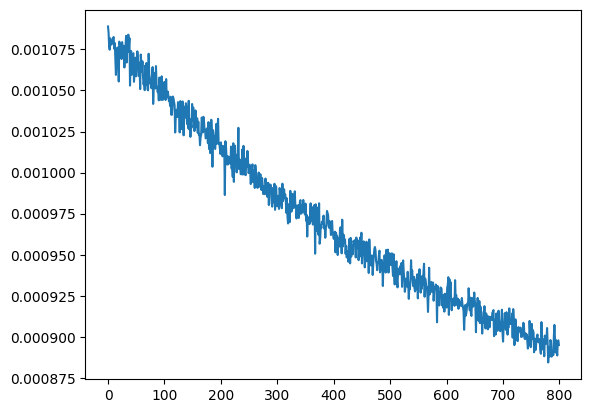

In [102]:
plt.plot(loss)

In [113]:
print("hello")

hello


In [114]:
test = model.predict(train_generator.__getitem__(1)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


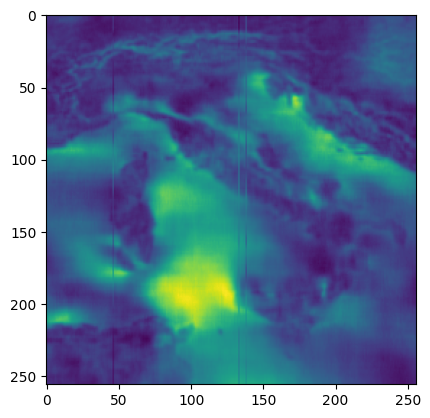

In [115]:
plt.imshow(test[0])

In [116]:
def experiment_espcn(generator, n_iter=100):
    #define final mse array 
    #raw = np.zeros((91,32,256,256))
    #bilinear = np.zeros((91,32,256,256))
    mses = np.zeros(n_iter)
    mses_baseline = np.zeros(n_iter)
    
    ssims = np.zeros(n_iter)
    psnrs = np.zeros(n_iter)
    
    ssims_baseline = np.zeros(n_iter)
    psnrs_baseline = np.zeros(n_iter)
    for i in range(n_iter):
        if(i%5 == 0):
            print(i)
        #select a random batch in the test set  
        sampin,sampout = generator.__getitem__(i)
        
        tmp = model.predict(sampin)
        
        sampin2 = np.zeros((sampin.shape[0],256,256,4))
        for l in range(sampin.shape[0]):
            for m in range(4):
                sampin2[l,:,:,m] = cv2.resize(sampin[l,:,:,m],(256,256),interpolation=cv2.INTER_LINEAR)
        sampin = sampin2
        
        mse = np.mean( ((sampout-np.squeeze(tmp))**2))
        ssims[i] = batch_ssim(sampout,np.squeeze(tmp))
        psnrs[i] = batch_psnr(sampout,np.squeeze(tmp))
        
        mse_baseline = np.mean( ((sampin[:,:,:,-2]-sampout)**2))
        ssims_baseline[i] = batch_ssim(sampin[:,:,:,-2],sampout)
        psnrs_baseline[i] = batch_psnr(sampin[:,:,:,-2],sampout)
        #print(mse.shape)
        # add 3 relevant meteric values to array 
        mses_baseline[i] = mse_baseline
        mses[i] = mse
        #raw[i] = np.squeeze(tmp)
        #bilinear[i] = sampin[:,:,:,-2]
    # return average of all mses
    return mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline#, raw, bilinear

In [117]:
full_test_generator = DataGeneratorMemmap(high_path_2020,low_path_2020, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2020,sequential=True,
                                      batch_size = 32, unet = True)

full_test_generator2009 = DataGeneratorMemmap(high_path_2009,low_path_2009, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2009,sequential=True,
                                      batch_size = 32, unet = True)

In [120]:
import time
full_test_generator.counter_reset()
start_time = time.time()  # Capture the start time
mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline = experiment_espcn(train_generator,91)
end_time = time.time()  # Capture the end time
execution_time = end_time - start_time 

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/s

In [121]:
print("ssim:", ssims.mean(), "  ssim baseline:", ssims_baseline.mean())

print("psnrs:", psnrs.mean(), "  psnrs_baseline:", psnrs_baseline.mean())

print("mse:", mses.mean(), "  mse baseline:", mses_baseline.mean())

ssim: 0.8087917387687212   ssim baseline: 0.7064434290816296
psnrs: 30.94530919487567   psnrs_baseline: 26.377881633931757
mse: 0.0008396707802223061   mse baseline: 0.002548527791145256


In [45]:
def print_results(a,b,c):
    
    for i in range(a.shape[0]):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5.5))
        
        ax = axes[0]
        ax.imshow(a[i,:,:,-1], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("last low res")
        
        ax = axes[1]
        ax.imshow(c[i,:,:], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("predicted")

        ax = axes[2]
        ax.imshow(b[i,:,:], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("ground truth")       

        plt.tight_layout()
        #plt.savefig("unet" + str(i) + ".png")
        plt.show()
        

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


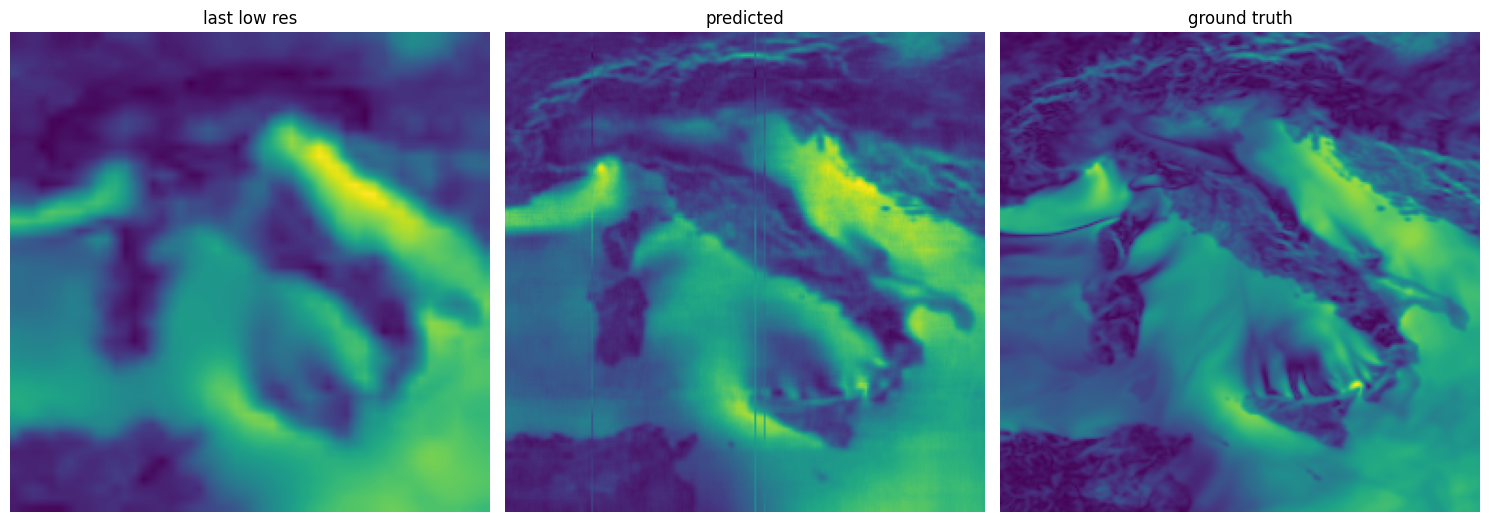

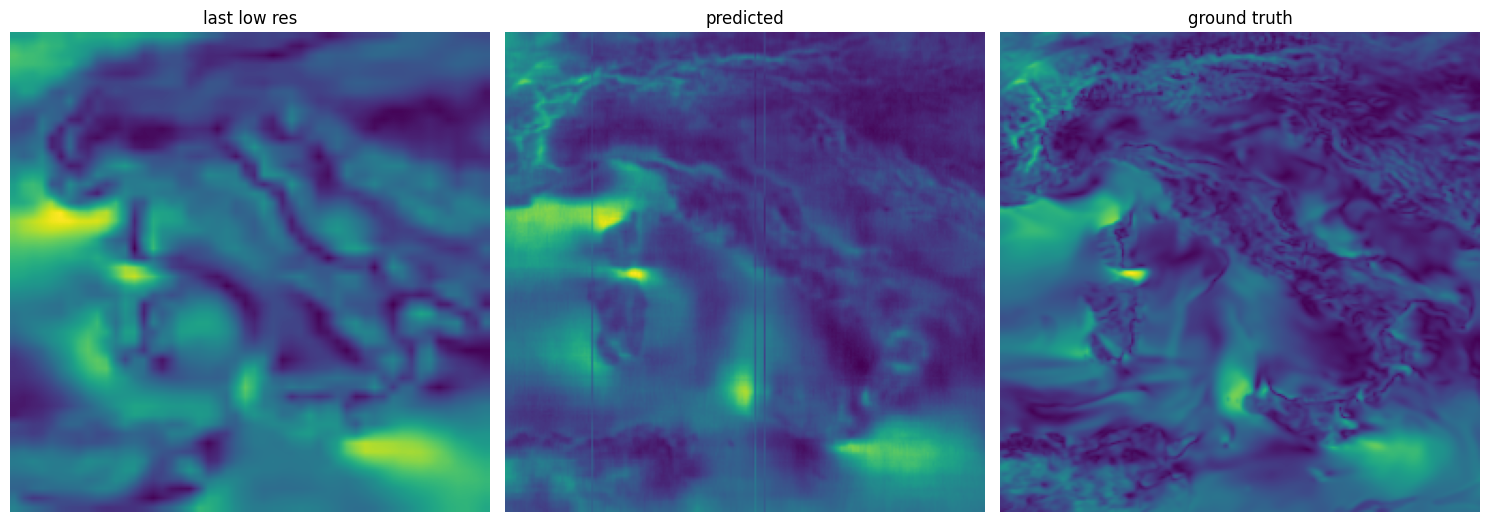

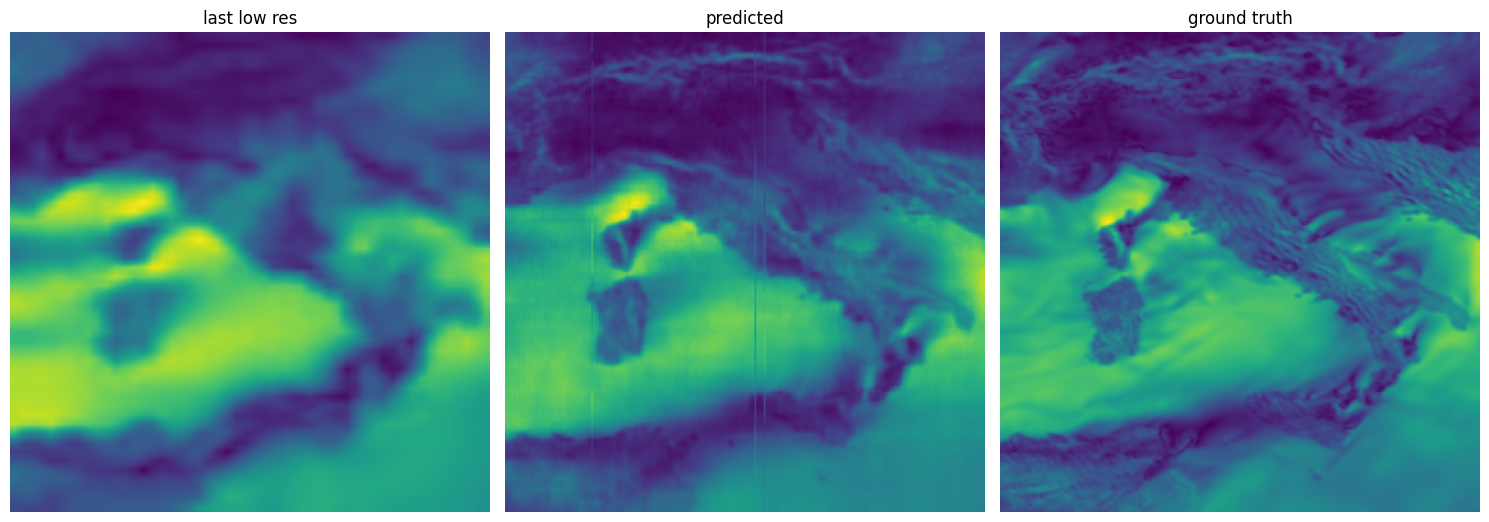

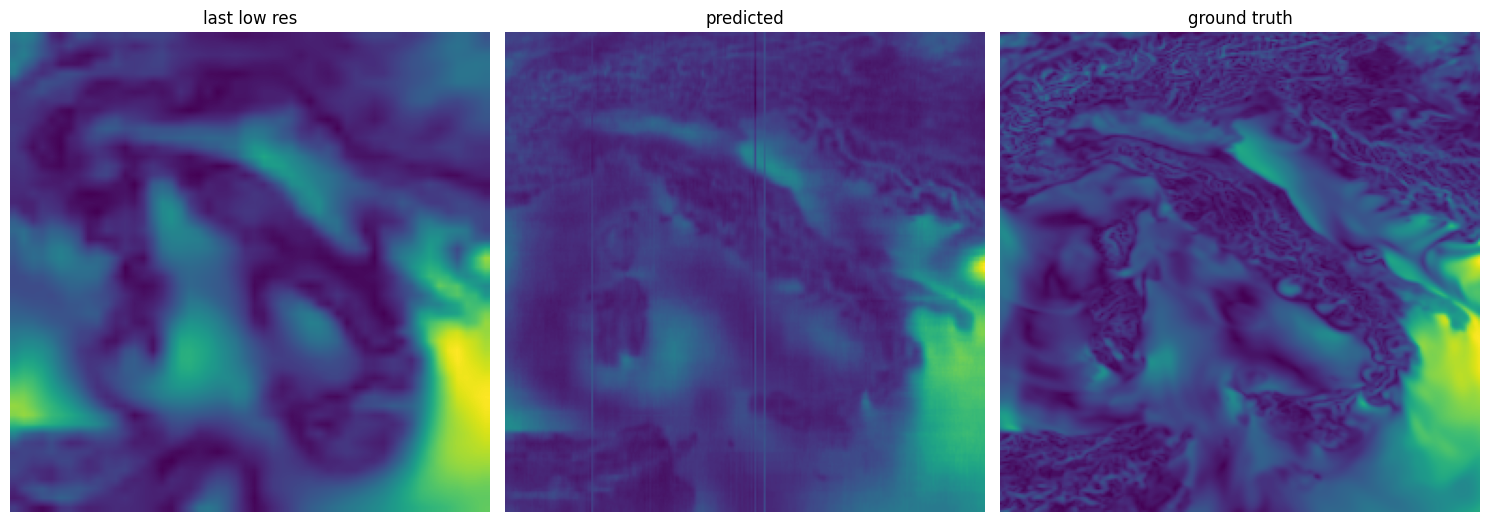

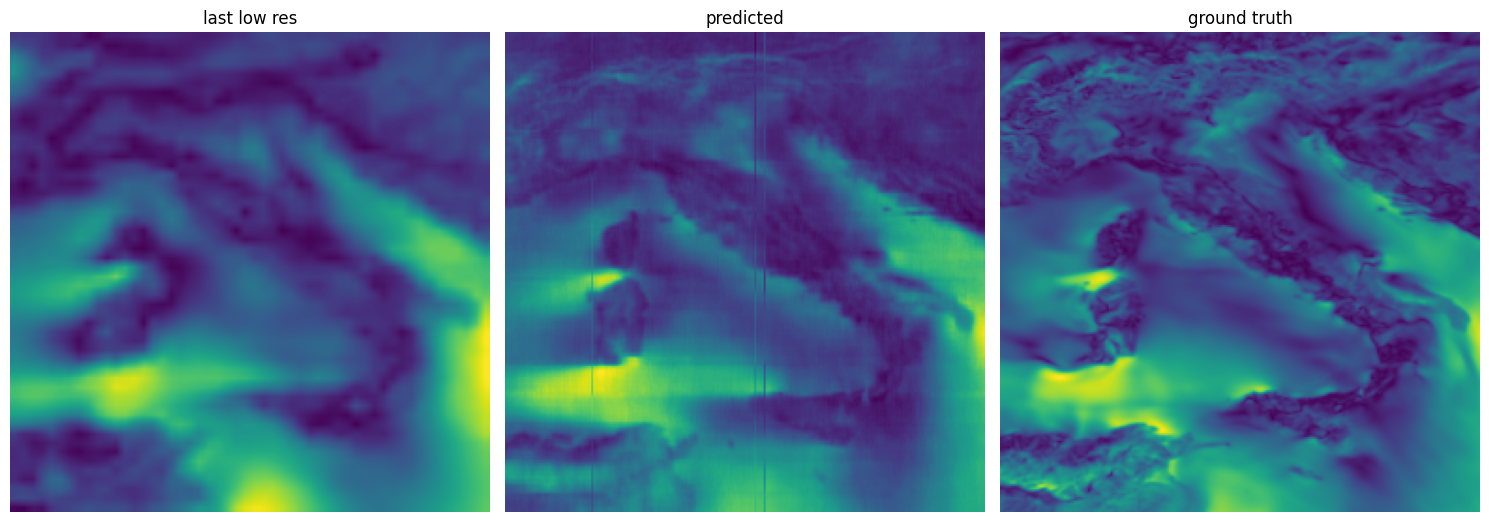

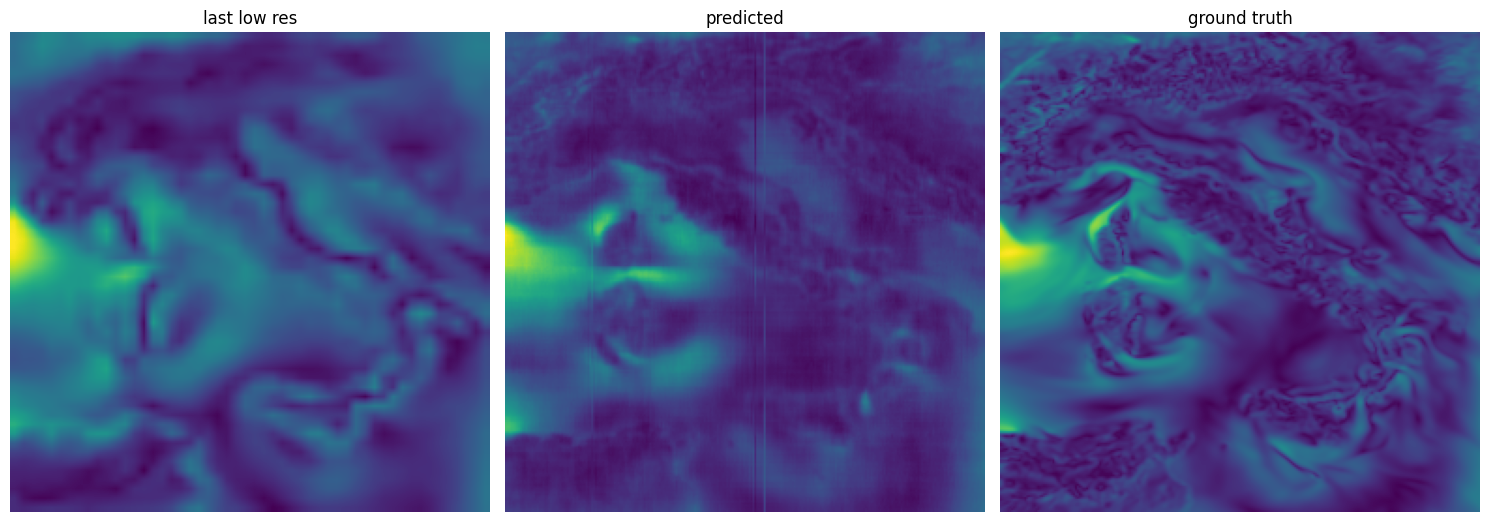

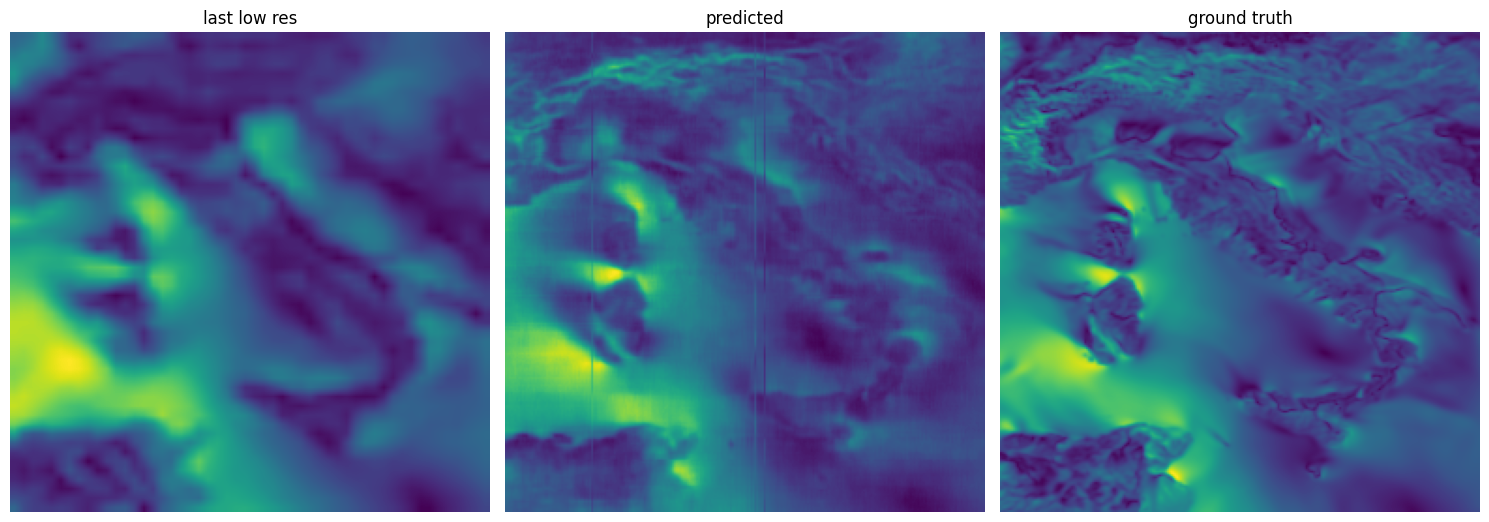

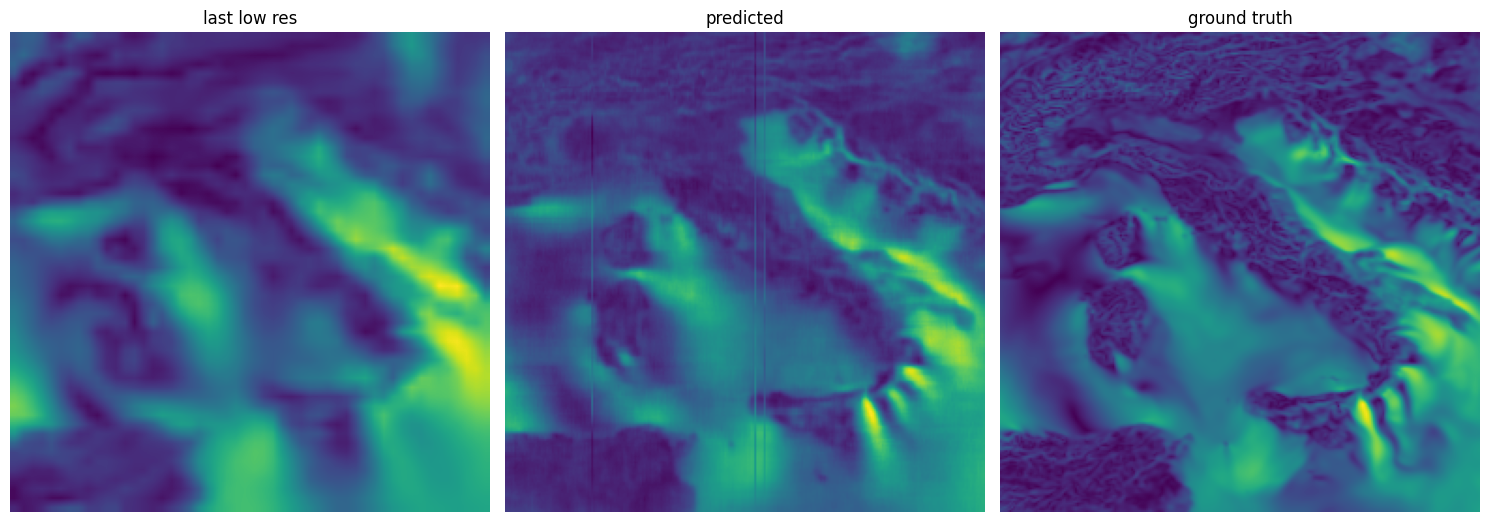

In [122]:
sampin,sampout = train_generator.__getitem__(1)
tmp = model.predict(sampin)

print_results(sampin,sampout,tmp)

In [ ]:


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")